# This spread sheet uses surface temperaturue measurements along with Other met and canopy variables and estimates of Rn G to give estimates of ET and compares with measurements

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import lmfit as fitter
import ETFunctions as et
from datetime import datetime
import matplotlib.dates as mdates
import MathsUtilities as MUte

## Bring in data

### Bring in the cover Data

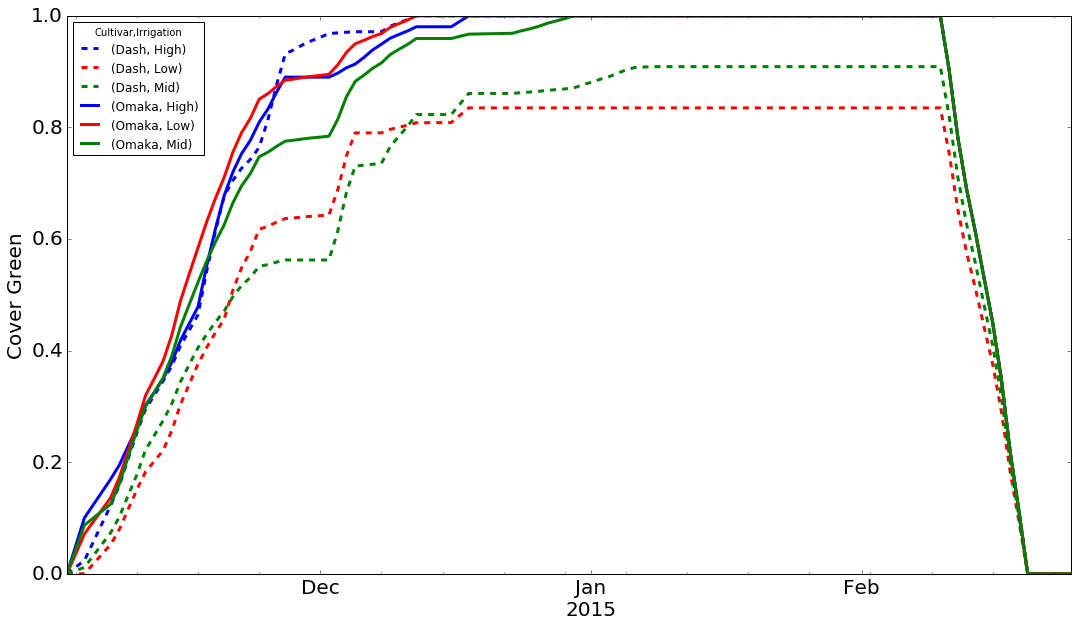

In [2]:
CoverData = pd.read_pickle('.\DataFrames\DailyFPAREstInt.pkl')
CoverData.sort_index(axis=1,inplace=True)
CoverData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Cover Green', fontsize = 20)

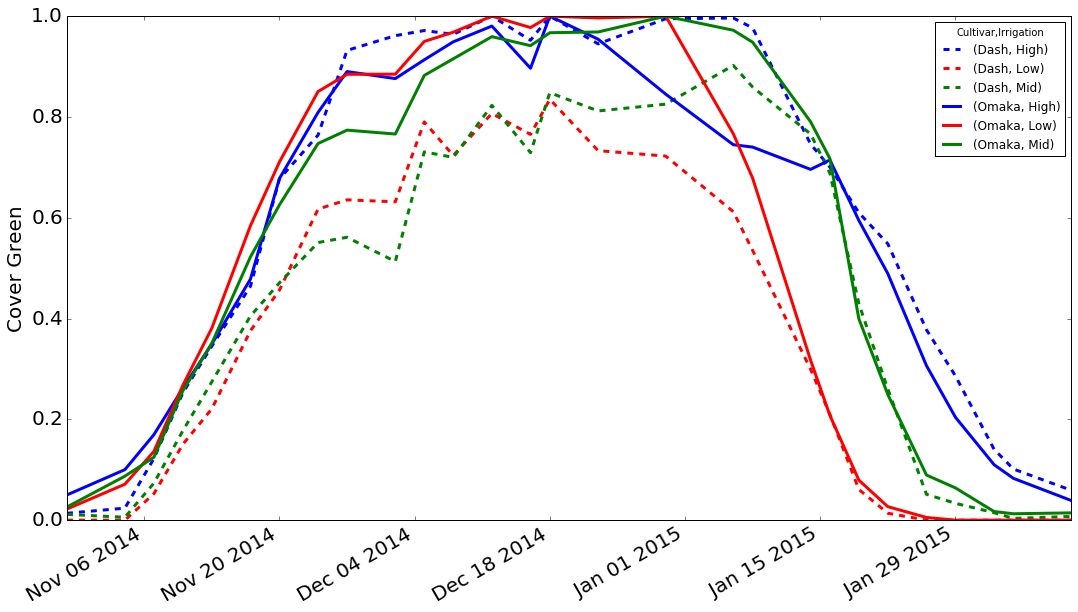

In [3]:
GreenCoverData = pd.read_pickle('.\DataFrames\FPARGreenEstimated.pkl')
GreenCoverData.sort_index(axis=1,inplace=True)
GreenCoverData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Cover Green', fontsize = 20)

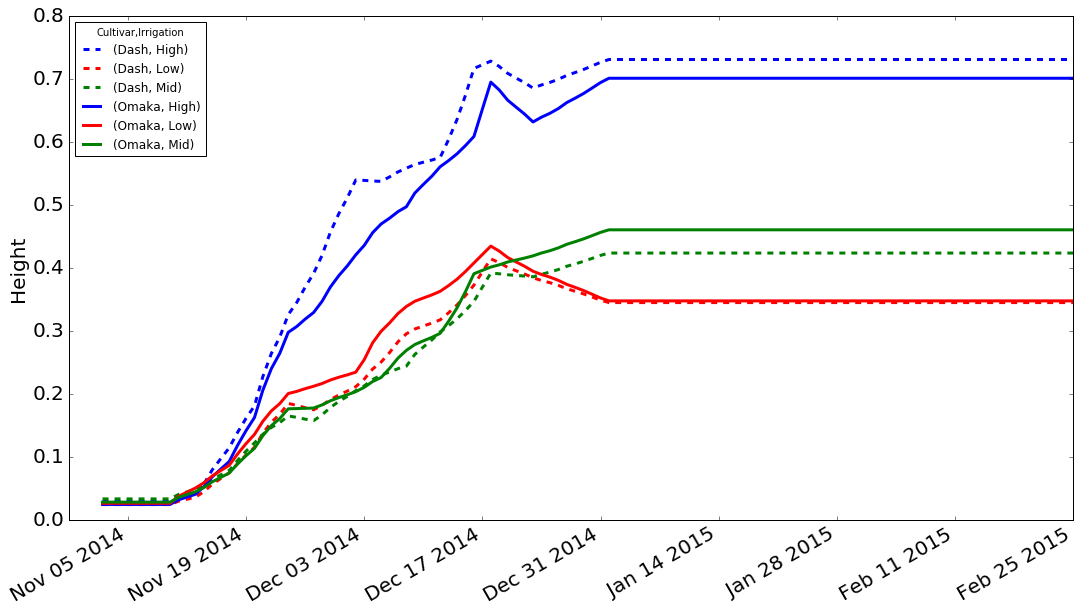

In [4]:
HeightData = pd.read_pickle('.\DataFrames\HeightEstimated.pkl')
HeightData.sort_index(axis=1,inplace=True)
HeightData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Height', fontsize = 20)

## Bring in the Energy Balance Data

In [5]:
EstRn = pd.read_pickle('.\DataFrames\EstNetRadiation.pkl')
EstG= pd.read_pickle('.\DataFrames\SoilHeatFluxDayEst.pkl')
HourlyWateruse = pd.read_pickle('.\DataFrames\HourlyWUmm.pkl')
HourlyWateruse.sort_index(axis=1,inplace=True)
TnRData = pd.read_pickle('.\DataFrames\TempAndMet.pkl')
TnRData.sort_index(axis=1,inplace=True)
TnRData.index.name='Date'
DayTimePET = pd.read_pickle('.\DataFrames\DayTimePET.pkl')
DayTimePET.index = DayTimePET.index.normalize()
TsULTa = pd.read_pickle('.\DataFrames\TsTaULDF.pkl')
ECT = '2014-11-08 00:00:00'
LCT = '2015-02-11 00:00:00'

Albedo = 0.23
Lattitude = -43.38
LongitudeTZ = 185
LongitudeML = 360 - 172.28
Cp = 1013 #Heat capacity of air Joule/kg/oC
#D=1200
D0 = 4000
T0 = 6
E1 = -0.00015
E0 = -0.0005
E = -0.0005
C1 = 1.2
C0 = 2
CB = 0.6
##Contract dataframes down to common index size
TnRData = TnRData.ix[ECT:LCT,:]

Irrigations = ['Low','Mid','High']
Cultivars = ['Dash','Omaka']
PlotList = [('Dash','Low','1'),('Dash','Low','2'),('Dash','Low','3'),('Dash','Low','4'),
('Dash','Mid','1'),('Dash','Mid','2'),('Dash','Mid','3'),('Dash','Mid','4'),
('Dash','High','1'),('Dash','High','2'),('Dash','High','3'),('Dash','High','4'),
('Omaka','Low','1'),('Omaka','Low','2'),('Omaka','Low','3'),('Omaka','Low','4'),
('Omaka','Mid','1'),('Omaka','Mid','2'),('Omaka','Mid','3'),('Omaka','Mid','4'),
('Omaka','High','1'),('Omaka','High','2'),('Omaka','High','3'),('Omaka','High','4')]

## Do some processing and cleaning

In [6]:
#Create a list of time to exclude where data was missing or irrigation was applied
NoMeasurementDates = ['2014-12-26','2014-12-27','2014-12-28']
IrrigationDates = ['2014-11-11','2014-11-18','2014-11-26','2014-12-02','2014-12-10','2014-12-16',
                    '2014-12-23','2014-12-30','2015-01-06','2015-01-13','2015-01-14']

ExclusionDates = IrrigationDates
for Date in NoMeasurementDates:
    ExclusionDates.append(Date)

#Exclude data from Temperature and radiation dataframe
ExclusionDateTimes5 = []
for Date in ExclusionDates:
    ExclusionDateTimes5 += pd.date_range(Date,periods=288,freq='5T')
TnRData = TnRData.ix[~TnRData.index.isin(ExclusionDateTimes5)]

# Make an index of all daylight hours in trial
HourlyTnRDataSum = TnRData.resample('h').sum()
HourlyTnRDataMean = TnRData.resample('h').mean()
DaylightIndex = HourlyTnRDataSum.ix[:,'IncomingRadnMJ'].where(HourlyTnRDataSum.ix[:,'IncomingRadnMJ']>0.02)
DaylightIndex.dropna(inplace=True)
DaylightIndex = DaylightIndex.index.to_datetime()

# Make day time means and sums for temperature and radiation data
DayTimeTnRDataMean = HourlyTnRDataMean.ix[DaylightIndex].resample('d').mean()
DayTimeTnRDataSum = HourlyTnRDataSum.ix[DaylightIndex].resample('d').sum()

# Make daily (day time) ET dataframe from hourly data excluding dark periods
ET = HourlyWateruse.ix[DaylightIndex].resample('d').sum()
ET = ET.ix[~ET.index.isin(ExclusionDates)]
ET = ET*-1
ET.index.name = 'Date'
ET.columns = ET.columns.swaplevel('Irrigation','Cultivar')

#Exclude non measurement and irrigation dates from Rn and G data frames
EstRn = EstRn.ix[~EstRn.index.isin(ExclusionDates, level=3)]
EstG = EstG.ix[~EstG.index.isin(ExclusionDates)]

#Exclude data from Surface Temperature upper limit dataframe and make daily mean
TsULTa = TsULTa.ix[~TsULTa.index.isin(ExclusionDateTimes5)]
HourlyTsULTa = TsULTa.resample('h').mean()
DayTimeTsULTaMean = TsULTa.ix[DaylightIndex].resample('d').mean()

In [7]:
def makeSeries(Var,Frame):
    SSeries= Frame.ix[Var]
    SSeries.name = Var
    SSeries.index = SSeries.index.droplevel()
    SSeries.index = SSeries.index.droplevel()
    return SSeries

In [8]:
#Start off data frame with net radiation data W/m2
EstRn.name = 'EstRn'
EstEnergyBalance = pd.DataFrame(EstRn)

#Make soil heat flux data long and join into energy balance data frame
EstG.index.name='Date'
EstGLong = EstG.unstack()
EstGLong.name = 'EstG'
EstEnergyBalance = EstEnergyBalance.join(EstGLong)

#Make surface temperature data long and join into energy balance data frame
TsTa = np.subtract(DayTimeTnRDataMean.ix[:,'IR_SurfaceTemp'] , DayTimeTnRDataMean.ix[:,'AirTemperature'])
TsTaLong = TsTa.unstack()
TsTaLong.name = 'Ts-Ta'
EstEnergyBalance = EstEnergyBalance.join(TsTaLong)

#Make surface temperature limit data long and join into energy balance data frame
DayTimeTsULTaMean.index.name = 'Date'
TsULTaLong = DayTimeTsULTaMean.unstack()
TsULTaLong.name = 'TsUL-Ta'
EstEnergyBalance = EstEnergyBalance.join(TsULTaLong)

#Duplicate Experiment level met data across all treatments and join into energy balance data frame
DateSet = EstEnergyBalance.ix[('Dash','Low','1'),:].index
TnRDataLong = DayTimeTnRDataMean.ix[DateSet].unstack()
LamdaSeries = makeSeries('lamda',TnRDataLong)
tempSeries = makeSeries('AirTemperature',TnRDataLong)
windSeries = makeSeries('Windspeed',TnRDataLong)
qSeries = makeSeries('q',TnRDataLong)
VPDSeries = makeSeries('VPD',TnRDataLong)
VPSeries = makeSeries('VP',TnRDataLong)
for plot in PlotList:
    #Hourly Water use in mm is equal to kg/m2 need to multiply by latent heat of vapourisation to convert to MJ
    EstEnergyBalance.ix[plot,'lamda'] = LamdaSeries.values
    EstEnergyBalance.ix[plot,'Ta'] = tempSeries.values
    EstEnergyBalance.ix[plot,'u'] = windSeries.values
    EstEnergyBalance.ix[plot,'q'] = qSeries.values
    EstEnergyBalance.ix[plot,'VPD'] = VPDSeries.values
    EstEnergyBalance.ix[plot,'Ea'] = VPSeries.values
    EstEnergyBalance.ix[plot,'PET'] = DayTimePET[EstEnergyBalance.ix[plot,'q'].index].values

#Join cover and green cover data into the data frame
EstEnergyBalance.ix[:,'Cover'] = CoverData.ix[DateSet].bfill().unstack()
EstEnergyBalance.ix[:,'GreenCover'] = GreenCoverData.ix[DateSet].bfill().unstack()
EstEnergyBalance.ix[:,'Height'] = HeightData.ix[DateSet].bfill().unstack()
    
#Calculate some other values    
EstEnergyBalance.ix[:,'qCp'] = EstEnergyBalance.ix[:,'q'] * Cp
EstEnergyBalance.ix[:,'uVPD'] = EstEnergyBalance.ix[:,'u'] * EstEnergyBalance.ix[:,'VPD']
EstEnergyBalance.ix[:,'Ts-TaqCp'] = EstEnergyBalance.ix[:,'Ts-Ta'] * EstEnergyBalance.ix[:,'q'] * Cp
EstEnergyBalance.ix[:,'EstRn-EstG'] = EstEnergyBalance.ix[:,'EstRn'] - EstEnergyBalance.ix[:,'EstG']

EstEnergyBalance.ix[:,'Ts'] = EstEnergyBalance.ix[:,'Ta'] + EstEnergyBalance.ix[:,'Ts-Ta']
EstEnergyBalance.ix[:,'To'] = EstEnergyBalance.ix[:,'Ts']  + 0 + EstEnergyBalance.ix[:,'VPD'] * 1
EstEnergyBalance.ix[:,'To-Ta'] =  EstEnergyBalance.ix[:,'To'] -  EstEnergyBalance.ix[:,'Ta'] 

EstEnergyBalance.ix[:,'TsUL'] = EstEnergyBalance.ix[:,'Ta'] + EstEnergyBalance.ix[:,'TsUL-Ta']
EstEnergyBalance.ix[:,'ToUL'] = EstEnergyBalance.ix[:,'TsUL'] + 0 +  EstEnergyBalance.ix[:,'VPD'] * 1
EstEnergyBalance.ix[:,'ToUL-Ta'] = EstEnergyBalance.ix[:,'ToUL'] - EstEnergyBalance.ix[:,'Ta']
EstEnergyBalance.ix[:,'(To-Ta)/(ToUL-Ta)'] = EstEnergyBalance.ix[:,'To-Ta']/EstEnergyBalance.ix[:,'ToUL-Ta']
EstEnergyBalance.ix[:,'(To-Ta)qCp'] = EstEnergyBalance.ix[:,'To-Ta'] * EstEnergyBalance.ix[:,'qCp']

IntIndex = range(EstEnergyBalance.index.size)
EstEnergyBalance.ix[:,'EqEvap'] = [et.Priestly_TaylorEO(EstEnergyBalance.ix[x,'EstRn-EstG'],EstEnergyBalance.ix[x,'Ta'],1,'net') for x in IntIndex]
EstEnergyBalance.ix[:,'PenEvap'] = [et.PenmanEO(EstEnergyBalance.ix[x,'EstRn-EstG'],EstEnergyBalance.ix[x,'Ta'],EstEnergyBalance.ix[x,'u'],EstEnergyBalance.ix[x,'Ea'],'net') for x in range(EstEnergyBalance.index.size)]

#Make water use data long and join into energy balance dataset
ETLong = ET.unstack()
ETLong.name = 'ET'
EstEnergyBalance = EstEnergyBalance.join(ETLong)

EstEnergyBalance.ix[:,'A'] = EstEnergyBalance.ix[:,'ET']/EstEnergyBalance.ix[:,'EqEvap']
EstEnergyBalance.ix[:,'1/A'] = 1/EstEnergyBalance.ix[:,'A']
EstEnergyBalance.ix[:,'LnA'] = np.log(EstEnergyBalance.ix[:,'A'])

#Calculate evapotranspiration
#EstEnergyBalance.ix[:,'FitA'] = [1/(EstEnergyBalance.ix[x,'To-Ta']*0.182 + 0.6852) for x in IntIndex]
EstEnergyBalance.ix[:,'FitA'] = [np.exp(0.34) * np.exp(EstEnergyBalance.ix[x,'To-Ta']*-0.14) for x in IntIndex]
EstEnergyBalance.ix[:,'Aresid'] = EstEnergyBalance.ix[:,'A'] - EstEnergyBalance.ix[:,'FitA']
EstEnergyBalance.ix[:,'AresidRel'] = EstEnergyBalance.ix[:,'A'] / EstEnergyBalance.ix[:,'FitA']

EstEnergyBalance.ix[:,'FitATs'] = [1/(EstEnergyBalance.ix[x,'Ts-Ta']*0.1589 + 0.8656) for x in IntIndex]
EstEnergyBalance.ix[:,'AresidTs'] = EstEnergyBalance.ix[:,'A'] - EstEnergyBalance.ix[:,'FitATs']
EstEnergyBalance.ix[:,'AresidRelTs'] = EstEnergyBalance.ix[:,'A'] / EstEnergyBalance.ix[:,'FitATs']


GCov = [0,0.5,1]   
CovR = [-.7,0,0]
EstEnergyBalance.ix[:,'CoverResp'] = [np.interp(EstEnergyBalance.ix[x,'GreenCover'],GCov,CovR) for x in IntIndex]
EstEnergyBalance.ix[:,'Alpha'] = EstEnergyBalance.ix[:,'FitA'] + EstEnergyBalance.ix[:,'CoverResp']
EstEnergyBalance.ix[:,'EstET'] = [et.Priestly_TaylorEO(EstEnergyBalance.ix[x,'EstRn-EstG'],EstEnergyBalance.ix[x,'Ta'],EstEnergyBalance.ix[x,'Alpha'],'net') for x in IntIndex]

#Calculate residual
EstEnergyBalance.ix[:,'ResidualET'] = EstEnergyBalance.ix[:,'ET'] - EstEnergyBalance.ix[:,'EstET']

#make a dataframe with treatment means
EstEBreorder = EstEnergyBalance.copy()
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Date','Cultivar')
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Irrigation','Block')
EBMeans = EstEBreorder.groupby(level=('Cultivar','Irrigation','Date'),axis=0).mean()

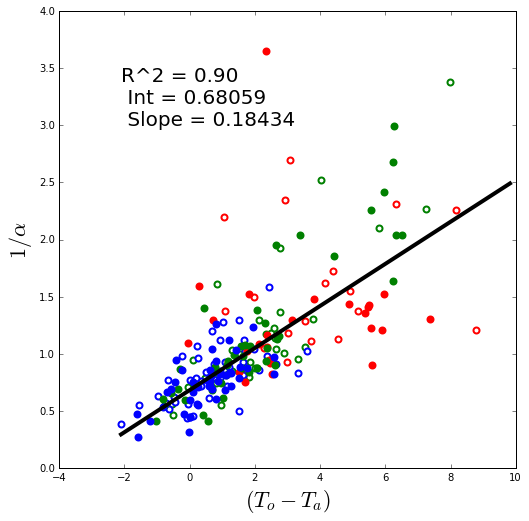

In [9]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (18,18))
fig = Comparison.add_subplot(2,2,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        CoverFilter = EBMeans.ix[(cul,irr),'GreenCover'] > 0.7
        Y = 1/EBMeans.ix[(cul,irr),'A'].ix[CoverFilter]
        X = EBMeans.ix[(cul,irr),'To-Ta'].ix[CoverFilter]
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1
CoverFilter = EBMeans.ix[:,'GreenCover'] > 0.5
Y = 1/EBMeans.ix[:,'A'].ix[CoverFilter]
X = EBMeans.ix[:,'To-Ta'].ix[CoverFilter]
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
fig.plot(Xs,Ys,'-', linewidth = 4, color='k')
fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
fig.text(X.min(),3,fitR2,fontsize=20)        
# x = [-2,-1,0.0,2.0,4.0,6.0,8.0,10.0]   
# y = 1/np.divide(5.8,np.add(x,4.7))
# plt.plot(x,y)
#plt.ylim(0,5)
#Comparison.savefig('Fig110.jpg',dpi = 1000)
plt.ylabel(r'$1/\alpha$', fontsize=22)
plt.xlabel(r'$(T_o-T_a)$',fontsize = 22)

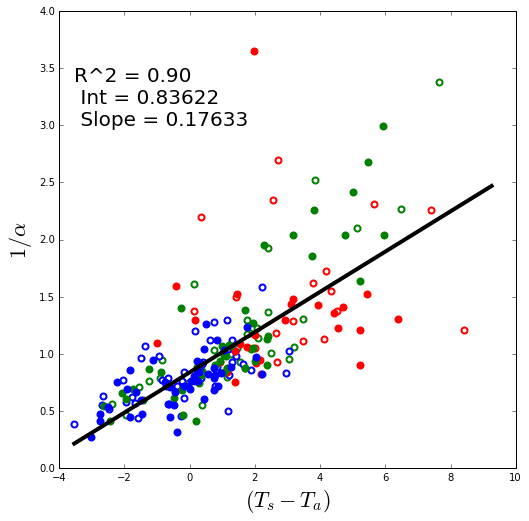

In [10]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (18,18))
fig = Comparison.add_subplot(2,2,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        CoverFilter = EBMeans.ix[(cul,irr),'GreenCover'] > 0.7
        Y = 1/EBMeans.ix[(cul,irr),'A'].ix[CoverFilter]
        X = EBMeans.ix[(cul,irr),'Ts-Ta'].ix[CoverFilter]
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1
CoverFilter = EBMeans.ix[:,'GreenCover'] > 0.5
Y = 1/EBMeans.ix[:,'A'].ix[CoverFilter]
X = EBMeans.ix[:,'Ts-Ta'].ix[CoverFilter]
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
fig.plot(Xs,Ys,'-', linewidth = 4, color='k')
fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
fig.text(X.min(),3,fitR2,fontsize=20)        
# x = [-2,-1,0.0,2.0,4.0,6.0,8.0,10.0]   
# y = 1/np.divide(5.8,np.add(x,4.7))
# plt.plot(x,y)
#plt.ylim(0,5)
#Comparison.savefig('Fig110.jpg',dpi = 1000)
plt.ylabel(r'$1/\alpha$', fontsize=22)
plt.xlabel(r'$(T_s-T_a)$',fontsize = 22)

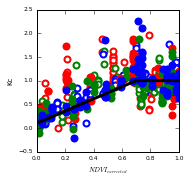

In [35]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (5.6,5.6))
fig = Comparison.add_subplot(2,2,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        CoverFilter = EBMeans.ix[(cul,irr),'GreenCover'] > 0
        Y = EBMeans.ix[(cul,irr),'AresidRel'].ix[CoverFilter]
        X = EBMeans.ix[(cul,irr),'GreenCover'].ix[CoverFilter]
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1
x = [0,0.7,1]   
y = [.1,1,1]
plt.plot(x,y, linewidth = 3)
plt.ylabel('Kc', fontsize = 7)
plt.xlabel('$NDVI_{corrected}$',fontsize = 7)
plt.tick_params(labelsize =6)
Comparison.savefig('Kc.jpg',dpi=1000)

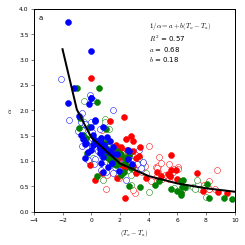

In [12]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (3.6,8))
fig = Comparison.add_subplot(2,1,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        CoverFilter = EBMeans.ix[(cul,irr),'GreenCover'] > 0.5
        Y = EBMeans.ix[(cul,irr),'A'].ix[CoverFilter]
        X = EBMeans.ix[(cul,irr),'To-Ta'].ix[CoverFilter]
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos])
        irrpos+=1
        culpos+=1
        
CoverFilter = EBMeans.ix[:,'GreenCover'] > 0.5
Y = 1/EBMeans.ix[:,'A'].ix[CoverFilter]
X = EBMeans.ix[:,'To-Ta'].ix[CoverFilter]
RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
Xs = [-2,-1,0.0,2.0,4.0,6.0,8.0,10.0]   
Ys = []
for x in Xs:
    Ys.append(1/(RegStats.Intercept + x*RegStats.Slope))
plt.plot(Xs,Ys,'-', linewidth = 2, color='k')
#plt.plot([0,13],[0,13],'-', linewidth = 3, color='k')
fitR2 = r'$1/\alpha = a + b(T_o-T_a) $'  \
    + '\n$R^2$ = ' + str(RegStats.R2)[:4]\
    + '\n$a$ = ' + str(RegStats.Intercept)[:4]\
    + '\n$b$ = ' + str(RegStats.Slope)[:4] 
plt.text(4,3,fitR2,fontsize=7) 
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left='on',right='off', labelright='off',labelsize=6, length = 3, direction = 'out', pad = 1)
plt.ylabel(r'$\alpha$', fontsize=7)
plt.xlabel(r'$(T_o-T_a)$',fontsize = 7)
plt.text(-3.7,3.8,'a',fontsize = 7)

# culpos = 0
# fig = Comparison.add_subplot(2,1,2)
# for cul in Cultivars:
#     irrpos = 0
#     for irr in Irrigations:
#         CoverFilter = EBMeans.ix[(cul,irr),'GreenCover'] > 0
#         Y = EBMeans.ix[(cul,irr),'Aresid'].ix[CoverFilter]
#         X = EBMeans.ix[(cul,irr),'GreenCover'].ix[CoverFilter]
#         plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos])
#         irrpos+=1
#         culpos+=1
# x = [0,0.5,1]   
# y = [-.6,0,0]
# plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=6,length = 3, direction = 'out', pad = 1)
# plt.tick_params(axis='y', which='both', left='on',right='off', labelright='off',labelsize=6, length = 3, direction = 'out', pad = 1)
# plt.ylabel(r'$\alpha\ residuals$', fontsize=7)
# plt.xlabel(r'$Green Cover$',fontsize = 7)
# plt.plot(x,y,linewidth=2)
# fig.yaxis.labelpad = 0
# plt.text(0.03,1.35,'b',fontsize = 7)
Comparison.savefig('Fig_8.jpg',dpi = 1000)

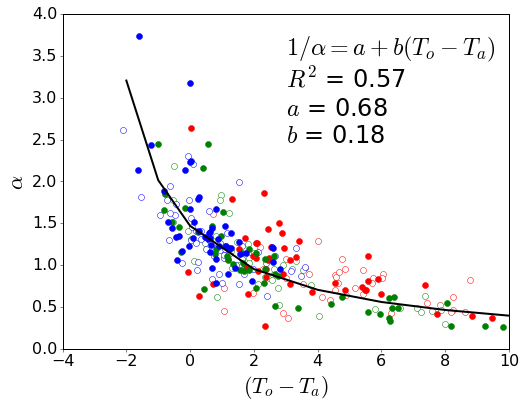

In [13]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (8,6))
fig = Comparison.add_subplot(1,1,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        CoverFilter = EBMeans.ix[(cul,irr),'GreenCover'] > 0.5
        Y = EBMeans.ix[(cul,irr),'A'].ix[CoverFilter]
        X = EBMeans.ix[(cul,irr),'To-Ta'].ix[CoverFilter]
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos])
        irrpos+=1
        culpos+=1
        
CoverFilter = EBMeans.ix[:,'GreenCover'] > 0.5
Y = 1/EBMeans.ix[:,'A'].ix[CoverFilter]
X = EBMeans.ix[:,'To-Ta'].ix[CoverFilter]
RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
Xs = [-2,-1,0.0,2.0,4.0,6.0,8.0,10.0]   
Ys = []
for x in Xs:
    Ys.append(1/(RegStats.Intercept + x*RegStats.Slope))
plt.plot(Xs,Ys,'-', linewidth = 2, color='k')
#plt.plot([0,13],[0,13],'-', linewidth = 3, color='k')
fitR2 = r'$1/\alpha = a + b(T_o-T_a) $'  \
    + '\n$R^2$ = ' + str(RegStats.R2)[:4]\
    + '\n$a$ = ' + str(RegStats.Intercept)[:4]\
    + '\n$b$ = ' + str(RegStats.Slope)[:4] 
plt.text(3,2.5,fitR2,fontsize=24) 
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=16,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left='on',right='off', labelright='off',labelsize=16, length = 3, direction = 'out', pad = 1)
plt.ylabel(r'$\alpha$', fontsize=22)
plt.xlabel(r'$(T_o-T_a)$',fontsize = 22)

(0, 2.5)

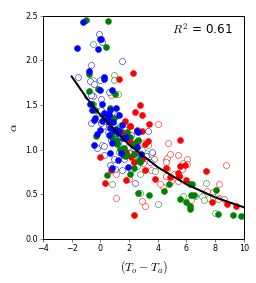

In [14]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (3.6,4))
fig = Comparison.add_subplot(1,1,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        CoverFilter = EBMeans.ix[(cul,irr),'GreenCover'] > 0.5
        Y = EBMeans.ix[(cul,irr),'A'].ix[CoverFilter]
        X = EBMeans.ix[(cul,irr),'To-Ta'].ix[CoverFilter]
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos])
        irrpos+=1
        culpos+=1
        
CoverFilter = EBMeans.ix[:,'GreenCover'] > 0.5
Y = np.log(EBMeans.ix[:,'A'].ix[CoverFilter])
X = EBMeans.ix[:,'To-Ta'].ix[CoverFilter]
RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
Xs = [-2,-1,0.0,2.0,4.0,6.0,8.0,10.0]   
Ys = []
Exp = []
for x in Xs:
    Ys.append(1/(RegStats.Intercept + x*RegStats.Slope))
    Exp.append(np.exp(0.3271)*np.exp(x*-.1362))
plt.plot(Xs,Exp,'-', linewidth = 2, color='k')
#fitR2 = r'$\alpha = e^a + e^{(T_o-T_a)*b} $'  \
fitR2 =  '\n$R^2$ = ' + str(RegStats.R2)[:4]\
    #+ '\n$p$ = ' + str(RegStats.Intercept)[:4]\
    #+ '\n$q$ = ' + str(-RegStats.Slope)[:4] 
plt.text(5,2.3,fitR2,fontsize=12) 
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=8,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left='on',right='off', labelright='off',labelsize=8, length = 3, direction = 'out', pad = 1)
plt.ylabel(r'$\alpha$', fontsize=12)
plt.xlabel(r'$(T_o-T_a)$',fontsize = 12)
plt.ylim(0,2.5)

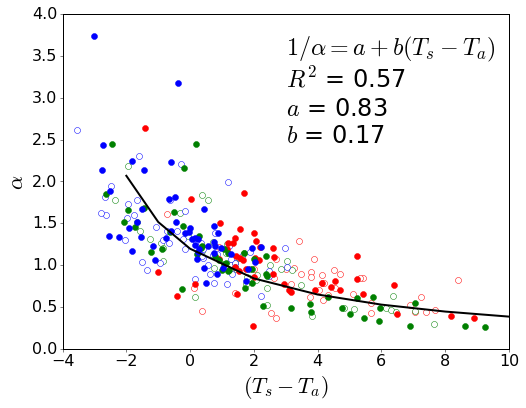

In [15]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (8,6))
fig = Comparison.add_subplot(1,1,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        CoverFilter = EBMeans.ix[(cul,irr),'GreenCover'] > 0.5
        Y = EBMeans.ix[(cul,irr),'A'].ix[CoverFilter]
        X = EBMeans.ix[(cul,irr),'Ts-Ta'].ix[CoverFilter]
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos])
        irrpos+=1
        culpos+=1
        
CoverFilter = EBMeans.ix[:,'GreenCover'] > 0.5
Y = 1/EBMeans.ix[:,'A'].ix[CoverFilter]
X = EBMeans.ix[:,'Ts-Ta'].ix[CoverFilter]
RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
Xs = [-2,-1,0.0,2.0,4.0,6.0,8.0,10.0]   
Ys = []
for x in Xs:
    Ys.append(1/(RegStats.Intercept + x*RegStats.Slope))
plt.plot(Xs,Ys,'-', linewidth = 2, color='k')
#plt.plot([0,13],[0,13],'-', linewidth = 3, color='k')
fitR2 = r'$1/\alpha = a + b(T_s-T_a) $'  \
    + '\n$R^2$ = ' + str(RegStats.R2)[:4]\
    + '\n$a$ = ' + str(RegStats.Intercept)[:4]\
    + '\n$b$ = ' + str(RegStats.Slope)[:4] 
plt.text(3,2.5,fitR2,fontsize=24) 
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=16,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left='on',right='off', labelright='off',labelsize=16, length = 3, direction = 'out', pad = 1)
plt.ylabel(r'$\alpha$', fontsize=22)
plt.xlabel(r'$(T_s-T_a)$',fontsize = 22)

In [16]:
CoverFilter = EstEnergyBalance.ix[:,'GreenCover'] > 0.5
FittingData = EstEnergyBalance.ix[:,('A','1/A','Ts-Ta','VPD','To-Ta','LnA')].ix[CoverFilter]
FittingData.ix[:,'1/A'] = FittingData.ix[:,'1/A'].where(FittingData.ix[:,'A']<2.5,np.nan)
FittingData.ix[:,'1/A'] = FittingData.ix[:,'1/A'].where(FittingData.ix[:,'A']>0.1,np.nan)
FittingData.ix[:,'LnA'] = FittingData.ix[:,'LnA'].where(FittingData.ix[:,'A']<2.5,np.nan)
FittingData.ix[:,'LnA'] = FittingData.ix[:,'LnA'].where(FittingData.ix[:,'A']>0.1,np.nan)
FittingData.ix[:,'A'] = FittingData.ix[:,'A'].where(FittingData.ix[:,'A']<2.5,np.nan)
FittingData.ix[:,'A'] = FittingData.ix[:,'A'].where(FittingData.ix[:,'A']>0.1,np.nan)


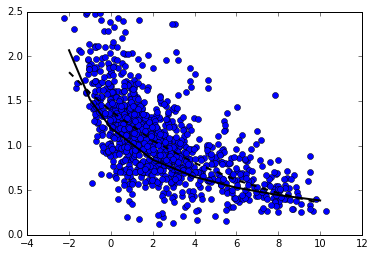

In [17]:
plt.plot(FittingData.ix[:,'To-Ta'],FittingData.ix[:,'A'],'o')
Xs = [-2,-1,0.0,2.0,4.0,6.0,8.0,10.0]   
Ys = []
Exp = []
for x in Xs:
    Ys.append(1/(RegStats.Intercept + x*RegStats.Slope))
    Exp.append(np.exp(0.3271)*np.exp(x*-.1362))
plt.plot(Xs,Ys,'-', linewidth = 2, color='k')
plt.plot(Xs,Exp,'--', linewidth = 2, color='k')
#plt.ylim(-1,10)

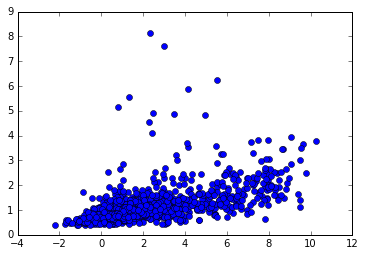

In [18]:
plt.plot(FittingData.ix[:,'To-Ta'],FittingData.ix[:,'1/A'],'o')

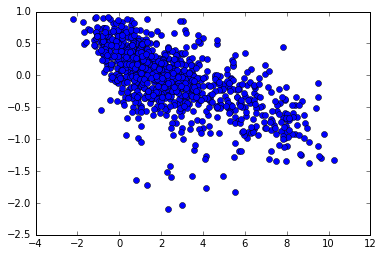

In [19]:
plt.plot(FittingData.ix[:,'To-Ta'],FittingData.ix[:,'LnA'],'o')

In [20]:
Descriptors = ['To-Ta']
X = FittingData.ix[:,FittingData.columns.isin(Descriptors)]
Y = FittingData.ix[:,'LnA']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    LnA   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     402.7
Date:                Wed, 20 Jun 2018   Prob (F-statistic):          2.66e-131
Time:                        13:19:33   Log-Likelihood:                -419.73
No. Observations:                1079   AIC:                             843.5
Df Residuals:                    1077   BIC:                             853.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.2663      0.015     17.349      0.000         0.236     0.296
To-Ta         -0.1270      0.005    -28.156      0.000        -0.136    -0.118
==============================================================================
Omnibus:                      257.529   Durbin-Watson:                   1.384
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              978.412
Skew:                          -1.100   Prob(JB):                    3.47e-213
Kurtosis:                       7.114   Cond. No.                         5.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

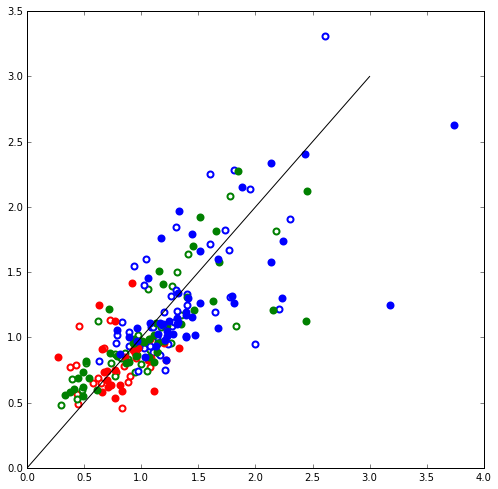

In [21]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (18,18))
fig = Comparison.add_subplot(2,2,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        CoverFilter = EBMeans.ix[(cul,irr),'GreenCover'] > 0.7
        Y = EBMeans.ix[(cul,irr),'FitATs'].ix[CoverFilter]
        X = EBMeans.ix[(cul,irr),'A'].ix[CoverFilter]
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1
x = [0,3]   
y = [0,3]
plt.plot(x,y)

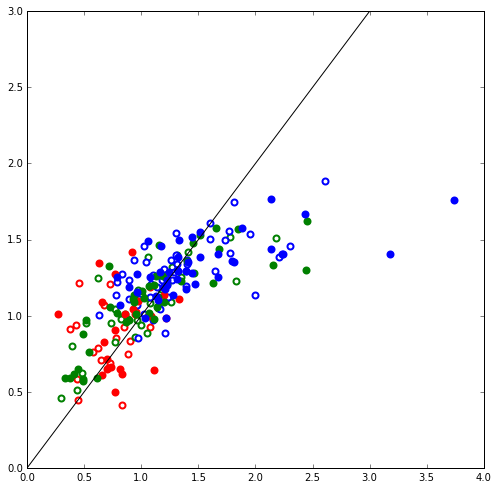

In [22]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (18,18))
fig = Comparison.add_subplot(2,2,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        CoverFilter = EBMeans.ix[(cul,irr),'GreenCover'] > 0.7
        Y = EBMeans.ix[(cul,irr),'FitA'].ix[CoverFilter]
        X = EBMeans.ix[(cul,irr),'A'].ix[CoverFilter]
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1
x = [0,3]   
y = [0,3]
plt.plot(x,y)

In [23]:
EBMeans.ix[(cul,irr),'EstET'].ix['2014-11-16':'2015-01-15'].values

array([ 2.59563473,  1.93734845,  4.50791765,  3.96145874,  7.92915503,
        5.14571703,  5.09896197,  6.61841611,  2.20655902,  9.20979255,
        1.6460691 ,  6.25654507,  5.02479975,  4.05581765,  5.09453704,
        4.01116985,  3.03978605,  5.0179094 ,  4.13253408,  4.47270178,
        4.94737804,  2.04625545,  4.44861949,  3.69524931,  7.09841735,
        7.47174452,  5.09490885,  3.4360525 ,  7.65378769,  3.78019414,
        4.94308064,  7.27646692,  7.67296864,  4.84212175,  7.76727485,
        5.44866836,  8.00088442,  9.03471866,  7.25229197,  8.45293993,
        8.67042035,  5.94631861,  3.68429232,  8.4764839 ,  9.79368913,
        3.48329974,  1.84431252,  4.93425937])

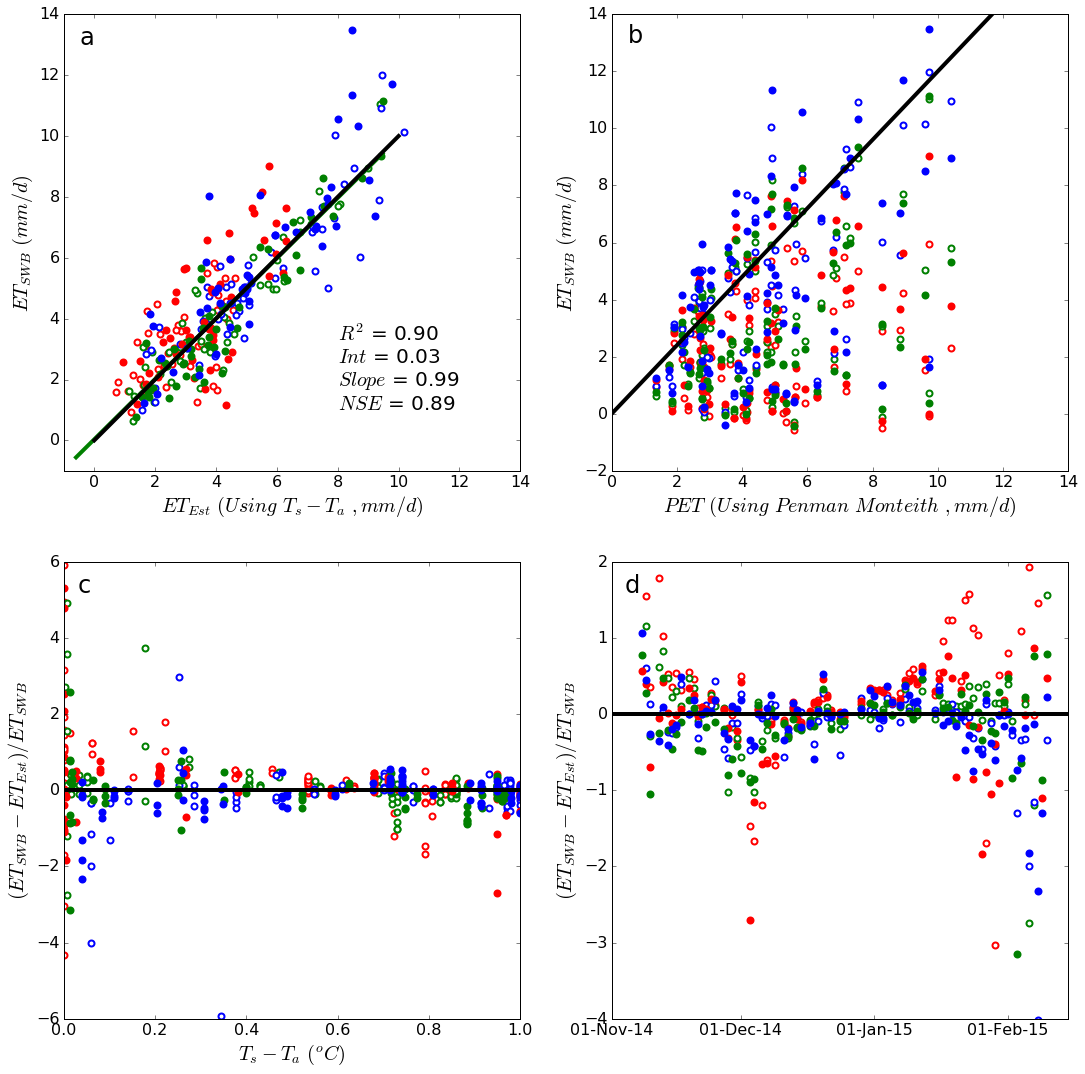

In [24]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (18,18))
fig = Comparison.add_subplot(2,2,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        Y = EBMeans.ix[(cul,irr),'ET'].ix['2014-11-16':'2015-01-15']
        X = EBMeans.ix[(cul,irr),'EstET'].ix['2014-11-16':'2015-01-15']
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1
#Make a binary filter to exclude High and Low reatments
ValidationFilter = (EBMeans.index.isin(['Mid'],level=1))#&(EBMeans.index.get_level_values(2)<'2015-01-15')
X = EBMeans.ix[ValidationFilter,'EstET'] 
Y = EBMeans.ix[ValidationFilter,'ET']
RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(RegStats.Intercept + Xs[0]*RegStats.Slope)
Ys.append(RegStats.Intercept + Xs[1]*RegStats.Slope)
plt.plot(Xs,Ys,'-', linewidth = 4, color='g')
plt.plot([0,10],[0,10],'-', linewidth = 4, color='k')
fitR2 = r'$R^2$ = ' + str(RegStats.R2)[:4]\
    + '\n$Int$ = ' + str(RegStats.Intercept)[:4] \
    + '\n$Slope$ = ' + str(RegStats.Slope)[:4]\
    + '\n$NSE$ = ' + str(RegStats.NSE)[:4] +''
plt.text(8,1.,fitR2,fontsize=20)        
plt.ylabel('$ET_{SWB}$ $(mm/d)$',fontsize=20)
plt.xlabel(r'$ET_{Est}$ $(Using$ $T_s-T_a$ $,mm/d)$',fontsize=20)
plt.tick_params(labelsize=16)
plt.text(-0.5,13,'a',fontsize=24)
plt.xlim(-1,14)
plt.ylim(-1,14)



fig = Comparison.add_subplot(2,2,2)
culpos = 0
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        Y = EBMeans.ix[(cul,irr),'ET']
        #X = DayTimePET.ix[Y.index]
        X = EBMeans.ix[(cul,irr),'PET']
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1
plt.plot([0,12],[0,14.4],'-', linewidth = 4, color='k')
plt.xlabel('$PET$ $(Using$ $Penman$ $Monteith$ $,mm/d)$',fontsize=20)
plt.tick_params(labelsize=16)
plt.ylim(-2,14)
plt.text(0.5,13,'b',fontsize=24)
plt.ylabel('$ET_{SWB}$ $(mm/d)$',fontsize=20)
#plt.legend(['Low Dash','Mid Dash','High Dash','Low Omaka','Mid Omaka','High Omaka'],loc=[-1.25,1.05],ncol=6,fontsize=18)
#plt.text(-8,16.5,'Irrigation level and cultivar treatments',fontsize=24)
plt.xlim(0,14)


fig = Comparison.add_subplot(2,2,3)
culpos = 0
for Cultivar in Cultivars:
    irrpos = 0 
    for Irrigation in Irrigations:
        yData = EstEnergyBalance.ix[(Cultivar,Irrigation),'ResidualET'].groupby(level='Date',axis=0).mean()
        yObs = EstEnergyBalance.ix[(Cultivar,Irrigation),'ET'].groupby(level='Date',axis=0).mean()
        xData = EstEnergyBalance.ix[(Cultivar,Irrigation),'GreenCover'].groupby(level='Date',axis=0).mean()
        plt.plot(xData,yData/yObs, 'o',  mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos += 1
        culpos +=1
plt.ylabel('$(ET_{SWB}-ET_{Est})/ET_{SWB}$', fontsize= 20)
plt.xlabel('$T_s-T_a$ $(^oC)$',fontsize=20)
plt.tick_params(labelsize = 16)
plt.text(0.03,5.2,'c',fontsize=24)
plt.ylim(-6,6)
plt.plot([0,1],[0,0],'-', linewidth = 4, color='k')

fig = Comparison.add_subplot(2,2,4)
culpos = 0
for Cultivar in Cultivars:
    irrpos = 0  
    for Irrigation in Irrigations:
        yData = EstEnergyBalance.ix[(Cultivar,Irrigation),'ResidualET'].groupby(level='Date',axis=0).mean()
        yObs = EstEnergyBalance.ix[(Cultivar,Irrigation),'ET'].groupby(level='Date',axis=0).mean()
        xData = yData.index
        plt.plot(xData,yData/yObs, 'o', mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos += 1
        culpos +=1
    plt.ylabel('$(ET_{SWB}-ET_{Est})/ET_{SWB}$', fontsize= 20)
plt.xlim('2014-11-1','2015-02-15')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=16)
plt.text('2014-11-4',1.6,'d',fontsize=24)
plt.ylim(-4,2)
plt.plot(['2014-11-1','2015-02-15'],[0,0],'-', linewidth = 4, color='k')

In [25]:
MakeCumGraph()

NameError: name 'MakeCumGraph' is not defined

In [ ]:
def MakeCumGraph():
    graph = plt.figure(figsize=(18,10))
    start = '2014-11-16'
    end = '2015-03-15'
    pos = 1
    for Irr in Irrigations:
        line = '-'
        for Cul in Cultivars:
            Pannel = graph.add_subplot(3,2,pos)    
            Data = EBMeans.ix[(Cul,Irr),:]
            plt.plot(Data.ix[start:end,'ET'].cumsum(),label = 'ET',linewidth = 2)
            plt.plot(Data.ix[start:end,'EstET'].cumsum(),label = 'EstET',linewidth = 2)
            #plt.plot(Data.ix[start:end,'PenEvap'].cumsum(),label='PenEvap',linewidth = 2)
            #plt.plot(Data.ix[start:end,'PrystTay'].cumsum(),label='PrystlyT',linewidth = 2)
            #plt.plot(Data.ix[start:end,'PenMon'].cumsum(),label='PenMon',linewidth = 2)
            diff = Data.ix[start:end,'EstET'].cumsum() - Data.ix[start:end,'ET'].cumsum()
            plt.plot(diff,linewidth = 2)
            plt.ylim(-50,400)
            plt.text('2014-11-15',350,Irr + ' ' + Cul,fontsize=16)
            line = '--'
            if pos == 1:
                plt.legend(loc=1)
            pos +=1

In [ ]:
EstEnergyBalance.PotET